#### Постановка задачи.

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по 
исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, 
какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

#### Задача 1:
    
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention 
игроков (по дням от даты регистрации игрока). Данные и имеют следующую структуру:

reg_data.csv – данные о времени регистрации
auth_data.csv - данные о времени захода пользователей в игру

#### Алгоритм решения задачи:

1. Прочитать данные.
2. Проверить в них наличие дубликатов и пропущенных значений.
3. Написать функцию подсчета retention.
4. Протестировать работу функции.
5. Визуализировать retention в Jupyter.
6. Визуалиировать retention в Tableau.

#### Импортирую необходимые модули:

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
import datetime as dt
import warnings


import time

from calculate_retention import CalculateRetention

In [ ]:
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 
оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Формат данных:

user_id  revenue   testgroup
1           0          b
2           0          a
3           0          a
4           0          b
5           0          b

#### Загружаю данные:

regs - данные о регистрации пользователей

auth - данные о входе в Приложение.

In [62]:
regs = pd.read_csv('./datasets/KarpovCourses/final/1/reg_data.csv', sep=';')

auth = pd.read_csv('./datasets/KarpovCourses/final/1/auth_data.csv', sep=';')

#### Эта функция мне нужна чтобы сходу понимать shape датафреймов и содержат ли какие-то колонки дубликаты:

In [3]:
def datasets_params(df1, df2):
    
    params = {'regs': ['shape', df1.shape, 'duplicated', df1.duplicated().sum()], 
              'auth': ['shape', df2.shape, 'duplicated', df2.duplicated().sum()],
             }
 
    return print(pd.DataFrame(params))

#### Смотрю на формы датасетов и на наличие в них дубликатов:

In [4]:
datasets_params(regs, auth)

           regs          auth
0         shape         shape
1  (1000000, 2)  (9601013, 2)
2    duplicated    duplicated
3             0             0


####  Проверяю на наличие пропущенных значений:

In [47]:
regs.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [48]:
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [49]:
regs.head(2)

,reg_ts,uid
0,911382223,1
1,932683089,2


In [33]:
auth.head(2)

,auth_ts,uid
0,911382223,1
1,932683089,2


In [32]:
regs.dtypes

reg_ts    int64
uid       int64
dtype: object

#### Трансформирую колонки из timestamp в datetime:

In [6]:
regs.reg_ts = pd.to_datetime(regs.reg_ts, unit='s').dt.date

auth.auth_ts = pd.to_datetime(auth.auth_ts, unit='s').dt.date

####  Произвожу слияние датафреймов:

In [7]:
def merge_to_total(df1, df2):
    
    return df1.merge(df2, on='uid', how='left')

In [8]:
df = merge_to_total(auth, regs)

df.head()

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22


#### Для удобства меняю порядок столбцов в объединенном датафрейме:

In [13]:
df = df.reindex(columns=['uid', 'reg_ts', 'auth_ts'])

df.head(2)

,uid,reg_ts,auth_ts
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22


#### Создаю колонку, c количеством дней, прошедших со дня регистрации:

In [10]:
df['num_days_after_reg'] = (df.auth_ts - df.reg_ts).dt.days + 1

df.head()

,auth_ts,uid,reg_ts,num_days_after_reg
0,1998-11-18,1,1998-11-18,1
1,1999-07-22,2,1999-07-22,1
2,1999-07-25,2,1999-07-22,4
3,1999-07-31,2,1999-07-22,10
4,1999-08-05,2,1999-07-22,15


#### Создаю когорты:

In [21]:
data = df.groupby(['reg_ts', 'num_days_after_reg']) \
         .uid.apply(pd.Series.nunique) \
         .reset_index()

data.head()

,reg_ts,num_days_after_reg,uid
0,1998-11-18,1,1
1,1999-07-22,1,1
2,1999-07-22,4,1
3,1999-07-22,10,1
4,1999-07-22,15,1


In [ ]:
#### Считаю retention:

In [ ]:
calc_cohort = data.pivot(index='reg_ts'), columns='num_days_after_reg', values='uid')
cohort_vol = calc_cohort.iloc[:,0]
retention = calc_cohort.divide(cohort_vol, axis=0) \
                       .round(3) \
                       .mul(100)

In [89]:
regs = pd.read_csv('./datasets/KarpovCourses/final/1/reg_data.csv', sep=';')

auth = pd.read_csv('./datasets/KarpovCourses/final/1/auth_data.csv', sep=';')

In [112]:
def retention(reg_data, auth_data, start, stop): 

    # Соединяю датасеты:
    df = reg_data.merge(auth_data, how='left', on='uid')
    
    # Перевожу колонки из datastamp в datetime:
    df.reg_ts = pd.to_datetime(df.reg_ts, unit='s')
    df.auth_ts = pd.to_datetime(df.auth_ts, unit='s')
    
    # Выделяю дату:
    df.reg_ts = df.reg_ts.dt.date
    df.auth_ts = df.auth_ts.dt.date
    
    # Повторно перевожу колонки из datastamp в datetime (автоматически стали object):
    df.reg_ts = pd.to_datetime(df.reg_ts)
    df.auth_ts = pd.to_datetime(df.auth_ts)
    
    # Оставляю данные в требуемом интервале:
    df = df.query('reg_ts >=@start and reg_ts <=@stop')
    
    # Считаю количество дней, прошедших с момента регистрации:  
    df['days_after_reg'] = (df.auth_ts - df.reg_ts).dt.days + 1
    
    # Создаю когорты:
    cohorts = df.groupby(['reg_ts', 'days_after_reg']) \
                .uid.apply(pd.Series.nunique) \
                .reset_index()

    # Считаю retention:
    cohorts_pivot = cohorts.pivot(index='reg_ts', columns='days_after_reg', values='uid')
    
    retention = cohorts_pivot.divide(cohorts_pivot.iloc[:,0], axis=0).mul(100).round(3)
    
    return retention.drop(retention.columns[0], axis=1)

In [113]:
retention = retention(regs, auth, '2020-09-01', '2020-09-23')

In [114]:
retention

days_after_reg,2,3,4,5,6,7,8,9,10,11,...,14,15,16,17,18,19,20,21,22,23
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-09-01,2.018,4.098,4.224,4.603,6.431,5.612,6.431,4.098,5.422,5.107,...,5.485,4.288,4.414,4.351,5.044,4.161,4.351,3.594,4.351,1.576
2020-09-02,2.519,3.904,4.660,5.668,6.234,7.116,6.297,4.849,4.093,5.668,...,4.345,4.975,5.290,4.156,4.849,3.904,3.715,4.660,2.645,NaN
2020-09-03,2.326,5.405,4.714,6.537,6.977,8.548,6.348,5.468,6.285,6.348,...,5.971,5.468,5.343,4.400,4.840,4.651,5.468,2.388,NaN,NaN
2020-09-04,2.009,3.641,3.641,5.148,6.403,7.282,4.959,5.336,4.331,5.650,...,5.587,4.394,4.520,4.520,4.269,4.771,2.637,NaN,NaN,NaN
2020-09-05,2.757,3.947,4.637,5.451,5.890,7.456,4.887,5.075,5.451,6.015,...,5.388,4.511,5.138,4.449,4.762,2.506,NaN,NaN,NaN,NaN
2020-09-06,3.127,4.315,5.441,5.629,5.879,6.817,6.066,5.816,5.503,4.878,...,5.191,5.503,4.565,4.816,2.564,NaN,NaN,NaN,NaN,NaN
2020-09-07,2.936,4.247,5.372,5.059,6.371,7.308,5.247,4.122,5.621,5.996,...,5.059,4.247,5.059,3.373,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,1.746,3.928,3.928,4.863,7.606,7.544,6.608,5.175,5.175,6.546,...,5.175,4.738,3.055,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,1.742,3.236,4.667,5.725,6.658,5.725,5.912,4.356,5.040,3.734,...,4.854,2.427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#### Создам функцию для визуализации retention:

In [106]:
def viz_retention(retention):
    
    retention.index = retention.index.strftime('%Y-%m-%d')
    plt.figure(figsize=(20,10))
    plt.title('Active users')
    ax = sns.heatmap(data=retention, annot=True, vmin=0.0)
    ax.set_yticklabels(retention.index)
    fig=ax.get_figure()
    return plt.show()

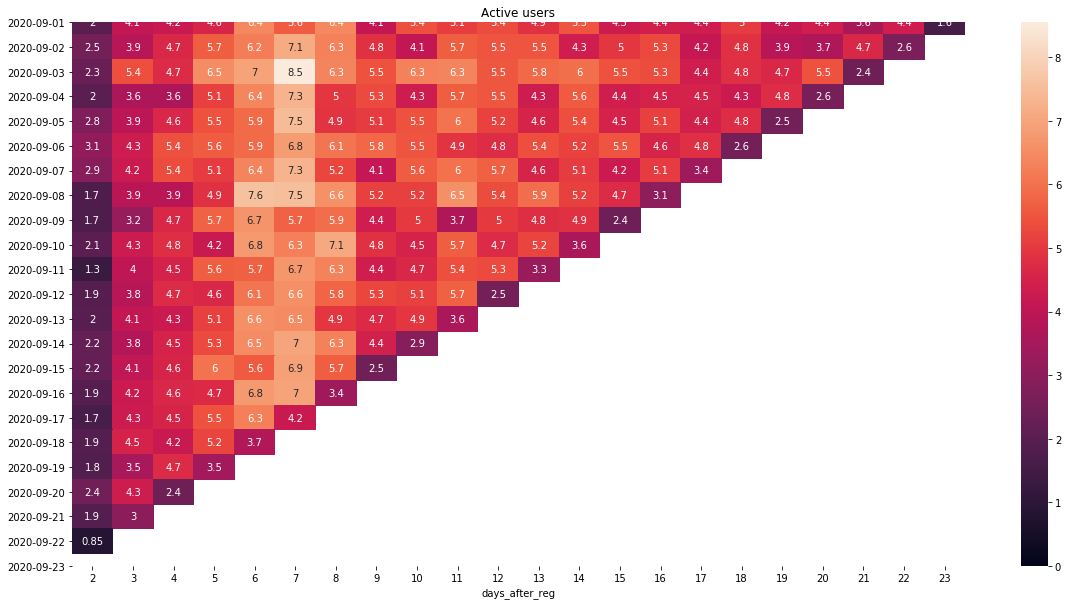

In [115]:
viz_retention(retention)

In [ ]:
#### Вывод: Retention у Приложения очень низкий, необходимы мероприятия для повышения вовлеченности.

#### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

#### Алгоритм решения:

Импортирую библиотеки.
Загружаю датасеты.
Смотрю структуру, типы данных, проверяю на наличие дубликатов и пропущенных значений.
Формирую рабочий датафрейм из загруженных датасетов.
Провожу разделение датасета на тестовую и контрольную группы.
Выделяю основные метрики для анализа для принятия решения об эффективности изменений по результатам АБ-теста.
Проверяю насколько изменились основные параметры в тестовой группе относительно контрольной группы.
Строю боксплоты для того чтобы оценить выбросы.
Оцениваю наличие и величину выбросов и принимаю решение что с ними делать.
Проверяю тестовую и контрольную выборки на нормальность.
Проверяю равномерность распределения данных в контрольной и тестовой группах.
Выбираю методы проверки статистической значимости выбранных метрик.
Осуществляю проверку на статистическую значимость. В зависимости от наличия выбросов с ними и без.
Делаю финальные выводы.

In [ ]:
#### Импортирую необходимые модули:

In [126]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#### Загружаю датасет:

In [106]:
df = pd.read_csv('./datasets/KarpovCourses/final/1/2nd_dataset.csv', sep=';')

In [107]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [169]:
#### Разделяю группы на тестовую и контрольную:

control = df.query('testgroup == "a"')

test = df.query('testgroup == "b"')

#### Проверяю форму распределения переменной revenue в датасетах и смотрю есть ли дубликаты, проверяю на наличие пропущенных значений:

In [174]:
def dataset_params(df1, df2):
    
    params = {'df1': ['shape', df1.shape, 'duplicated', df1.duplicated().sum()],
              'df2': ['shape', df2.shape, 'duplicated', df2.duplicated().sum()]
             }
 
    return print(pd.DataFrame(params))

In [175]:
dataset_params(control, test)

           df1          df2
0        shape        shape
1  (202103, 3)  (202667, 3)
2   duplicated   duplicated
3            0            0


In [118]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [ ]:
#### Проверяю как распределены данные в контротльной и тестовой группах, есть ли явные выбросы:

In [119]:
# Создаю функцию для построения боксплота:

def boxplot_builder(df):
    
    plt.figure(figsize=(16,16))

    return sns.boxplot(x='testgroup', y ='revenue', data=df)

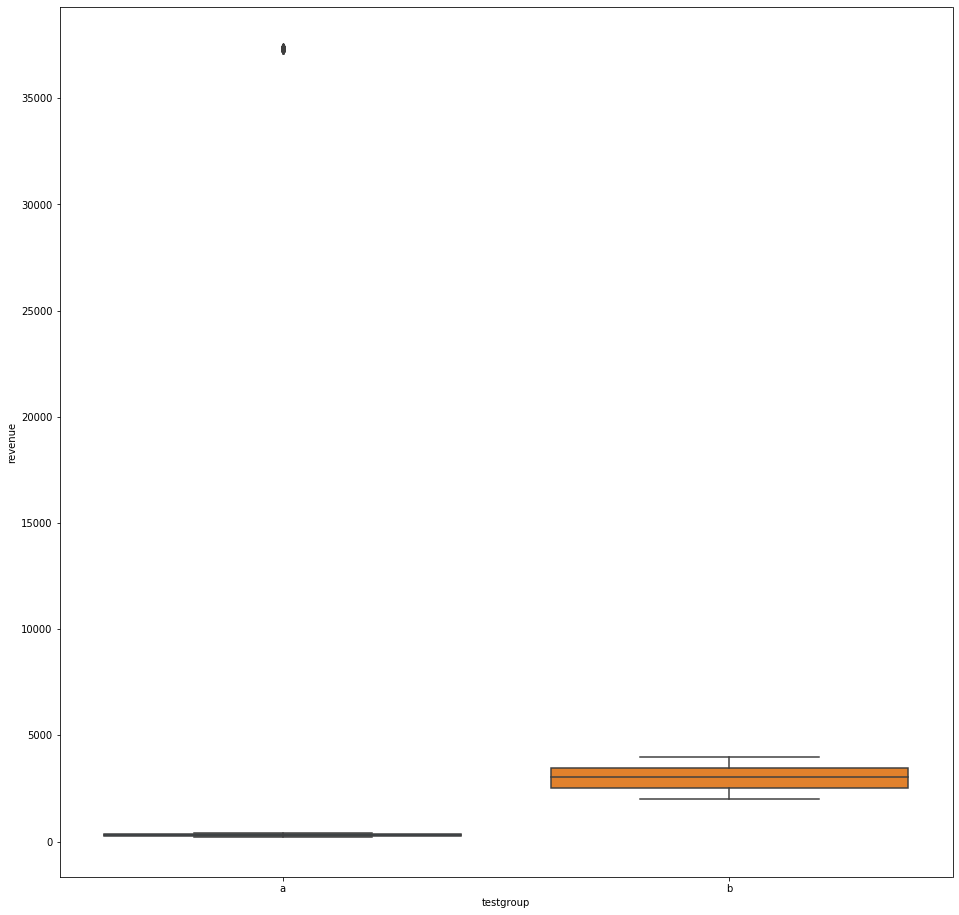

In [159]:
boxplot_builder(df.query('revenue != 0'))

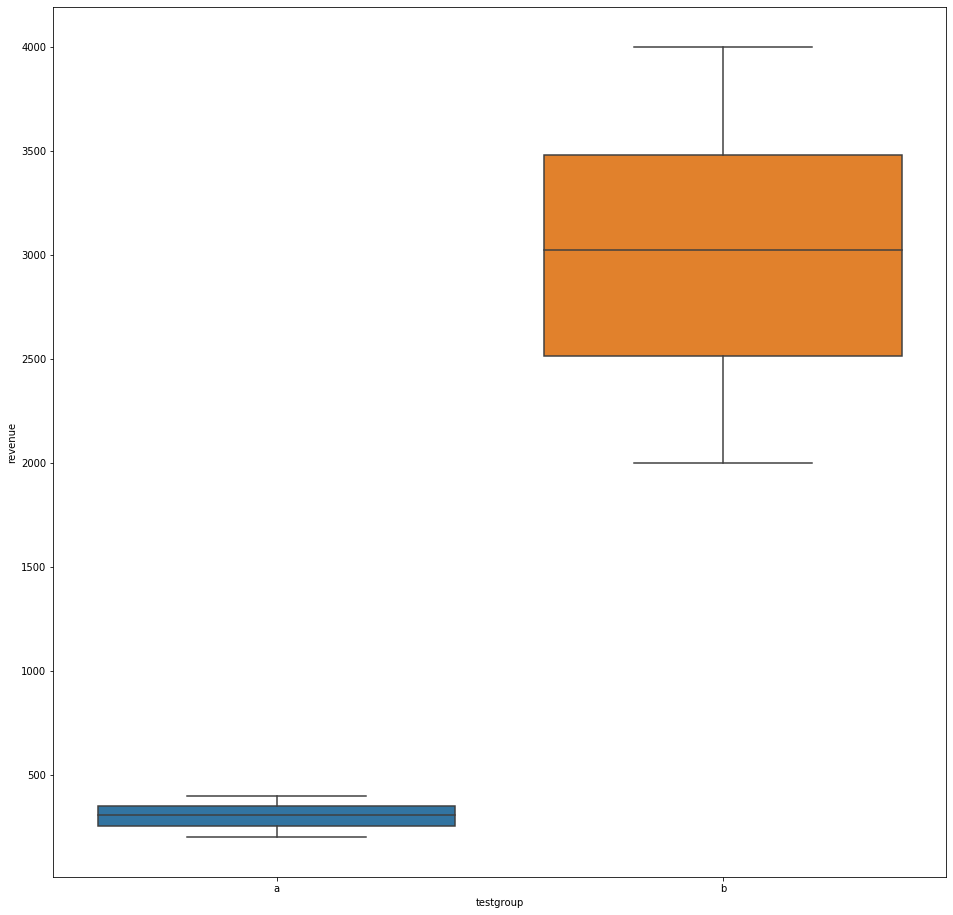

In [163]:
df_test = df.query('revenue != 0 & revenue < 35000')

boxplot_builder(df_test)

In [ ]:
#### Выводы: После старта акций в обеих группах наблюдается рост покупок на большое суммы. Причем в группе b заметно
увеличение чека в определенном диапазоне, а в группе а совершен ряд покупок на очень большие суммы и некоторое количество 
покупок незначительно превышающих усы боксплота. Поисследуем эти значения.



В одной из групп - посчитать количество записей и назвать ее есть значение, которое как мне кается является явным выбросом.
Попробую его убрать (написать гипотезу о том что это может быть), потому что это значение ли значения не характерны для большинства наблюдений...

In [ ]:
####  Смотрю какой вклад в бщий объем продаж в группе а привносят "выбросы"

In [165]:
df.query('revenue > 500 & testgroup == "a"').revenue.count()

123

In [190]:
100 * round(control.query('revenue > 500').revenue.sum()/test.revenue.sum(), 2)

85.0

In [180]:
control.shape[0]

202103

In [184]:
control.user_id.nunique()

202103

In [186]:
df.query('revenue > 500 & testgroup == "a"').user_id.nunique()

123

In [188]:
100 * df.query('revenue > 500 & testgroup == "a"').user_id.nunique()/df.user_id.nunique()

0.030387627541566816

In [ ]:
Получается что в контрольной группе 123 клиента (0.03 % от всех клиентов)(в супертоп ценовом сегменте) приносят 84% от 
общего ревенью.

In [ ]:
def payment_distribution(serie):
    
    null = serie.

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


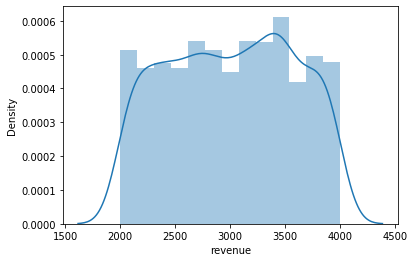

In [197]:
sns.distplot(test.query('revenue != 0').revenue)

In [198]:
test.query('revenue != 0').revenue.count()

1805

In [ ]:
#### Напишу функцию для проверки основных параметров в а и б группах:

In [215]:
def before_after_params(df1, df2):
    
    Paying_conversion = 100 * control.query('revenue != 0').user_id.nunique()/control.user_id.count()
    Revenue = control.revenue.sum()
    ARPU = control.revenue.sum()/control.user_id.count()
    AOV = control.revenue.sum()/control.agg({'revenue': 'count'}).item()
    all_clients = control.user_id.nunique()
    active_users = control.shape[0]
    paying_users = control.agg({'revenue': 'count'}).item()
    
    Paying_conversion1 = 100 * test.query('revenue != 0').user_id.nunique()/test.user_id.count()
    Revenue1 = test.revenue.sum()
    ARPU1 =  test.revenue.sum()/test.user_id.count()
    AOV1 = test.revenue.sum()/test.agg({'revenue': 'count'}).item()
    all_clients1 = test.user_id.nunique()
    active_users1 = test.shape[0]
    paying_users1 = test.agg({'revenue': 'count'}).item()
#   


    outcomes = {'Control': ['Paying conversion', Paying_conversion, 'Revenue', Revenue, 'ARPU', ARPU, 'AOV', AOV, 'num_users', all_clients, 'active users', active_users, 
                            'Paying users', paying_users], 
                'Test': ['Paying conversion', Paying_conversion, 'Revenue', Revenue1, 'ARPU', ARPU1, 'AOV', AOV1, 'num_users', all_clients1, 'active users', active_users1, 
                         'Paying users', paying_users1],
                'Difference': ['Paying conversion difference', Paying_conversion1 - Paying_conversion, 'Revenue difference', Revenue1 - Revenue, 'ARPU difference', ARPU1 - ARPU, 
                               'AOV difference', AOV1 - AOV, 'Difference in number of users', all_clients1 - all_clients, 
                               'Active users difference', active_users1 - active_users,
                               'Paying users difference', paying_users1 - paying_users]
               }
 
    return print(pd.DataFrame(outcomes))

In [216]:
before_after_params(control, test)

              Control               Test                     Difference
0   Paying conversion  Paying conversion   Paying conversion difference
1            0.953969           0.953969                     -0.0633455
2             Revenue            Revenue             Revenue difference
3             5136189            5421603                         285414
4                ARPU               ARPU                ARPU difference
5             25.4137            26.7513                        1.33757
6                 AOV                AOV                 AOV difference
7             25.4137            26.7513                        1.33757
8           num_users          num_users  Difference in number of users
9              202103             202667                            564
10       active users       active users        Active users difference
11             202103             202667                            564
12       Paying users       Paying users        Paying users dif

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: `item` has been deprecated and will be removed in a future version
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: `item` has been deprecated and will be removed in a future version
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: `item` has been deprecated and will be removed in a future version


In [218]:
#### Забавный вывод - условия задачи не соответствуют полученным числам из данных. Конверсия незначительно упала, ARPU выросла
на 1.3 п.п.

user_id      200862
revenue      200862
testgroup    200862
dtype: int64

In [ ]:
####  Смотрю какой вклад в бщий объем продаж привносят "выбросы"

In [168]:
df.query('testgroup == "b"').revenue.sum()

5421603

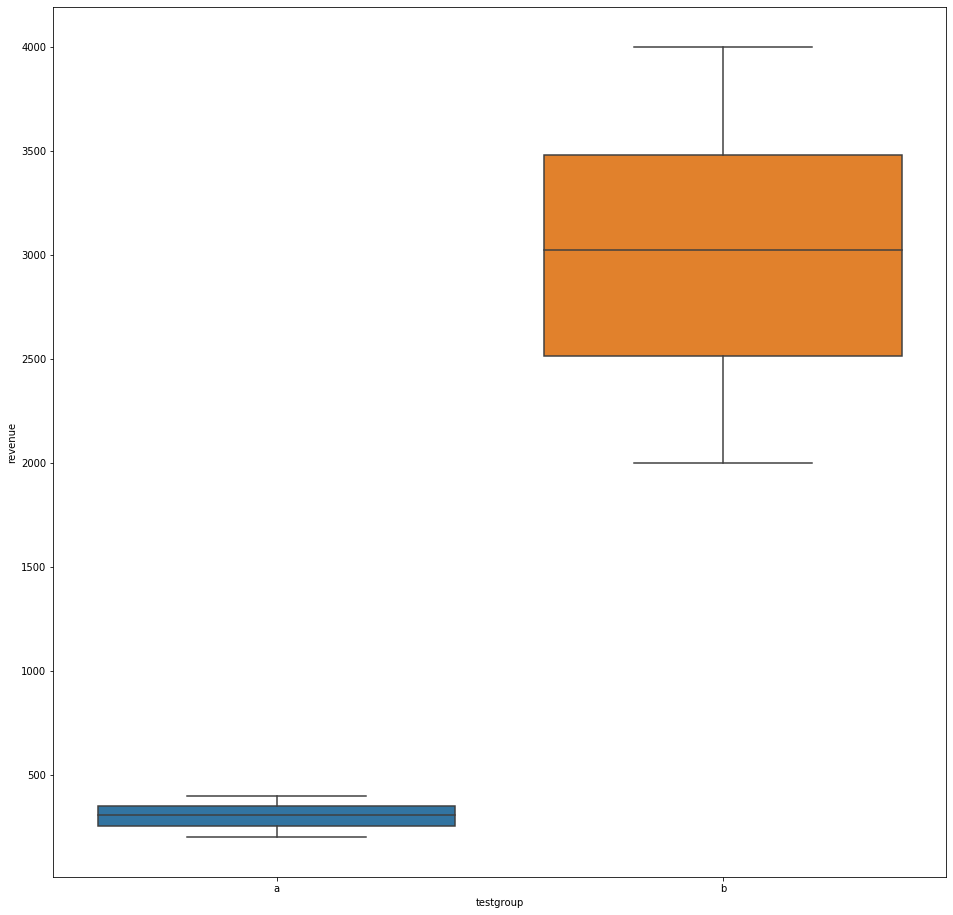

In [178]:
boxplot_builder(df.query('revenue != 0 & revenue < 35000'))

In [ ]:
#### Выводы:

In [ ]:
#### Посмотреть количество клиентов, находящихся за пределами усов и какой доход они генерят относительно дохода а пределах усов...

Какое это количество покупателей.Что о них моно предварительно сказать...

In [ ]:
!!!!!!!!!!!!! ТЕСТЫ

In [ ]:
# Создаю функцию, которая позволит проверять гипотезы с помощью бутстрапа для оценки среднего значения:

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    return p_value




# Создаю функцию, которая позволит проверять гипотезы с помощью бутстрапа для оценки медианы:
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
           
    return p_value

In [220]:
control.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [221]:
control['arpu'] = control.revenue/control.user_id.nunique()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [222]:
control.head()

,user_id,revenue,testgroup,arpu
1,2,0,a,0.0
2,3,0,a,0.0
9,10,0,a,0.0
10,11,0,a,0.0
11,12,0,a,0.0


In [ ]:
Задание 3:

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить 
уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд 
уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок 
будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?